<a href="https://colab.research.google.com/github/Zardian18/Fine-Tuning/blob/master/05_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using fine tuning

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2023-08-20 15:13:55--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10128 (9.9K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   9.89K  --.-KB/s    in 0s      

2023-08-20 15:13:55 (110 MB/s) - ‘helper.py’ saved [10128/10128]



In [2]:
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

We are going to use pre-trained model within `tf.keras.applications` and apply them to our own problems

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-08-20 15:14:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.2MB/s    in 8.7s    

2023-08-20 15:14:09 (18.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [5]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

This time, the data is in form of Batches and labels are one hot encoded, i.e. 1 for where the label is 1, else 0 everywhere

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# see and example of batch data
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for images, labels in train_data_10_percent.take(1): # taking 1 batch
  print(images, labels)

tf.Tensor(
[[[[125.62102    77.62102    54.621014 ]
   [120.14285    74.14285    51.142857 ]
   [113.19196    69.62739    50.357143 ]
   ...
   [ 66.27022    32.62743    17.841694 ]
   [ 66.646545   34.385387   19.385386 ]
   [ 69.61834    37.357178   22.357178 ]]

  [[123.79018    77.35714    54.357143 ]
   [118.57589    73.35937    51.92634  ]
   [110.9308     69.00223    49.90944  ]
   ...
   [ 69.226715   32.170128   18.783482 ]
   [ 71.20537    34.28796    20.854923 ]
   [ 73.491104   36.573696   23.14066  ]]

  [[120.24314    75.85475    55.46636  ]
   [116.2036     71.81521    51.426815 ]
   [109.011795   68.720184   50.571426 ]
   ...
   [ 72.02602    32.454544   20.24028  ]
   [ 74.09329    34.09329    22.093288 ]
   [ 76.55376    36.553757   24.553755 ]]

  ...

  [[211.64285   183.64285   179.64285  ]
   [213.02184   184.02184   178.02184  ]
   [214.70837   184.06552   176.2798   ]
   ...
   [252.30579   219.30579   202.30579  ]
   [252.30579   219.30579   201.69421  ]
   [2

Here the labels are one hot encoded as we can see

## Building models using tf.keras.applications

In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [12]:
model1= MobileNetV2(weights="imagenet")
preds= model1.predict(train_data_10_percent)

24/24 [==============================] - 14s 67ms/step


## Model 0: baseline model

In [13]:
# 1. create base model with tf.keras.applications
base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the patterns arent updated)
base_model.trainable=False

# 3. create input layer
input= tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

## if using a model like ResNet50V2 you will need to normalize the inputs
# x= tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(input)

# 5. pass inputs to the base mode
x= base_model(input)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs (aggregate most important features and reduce the number of computation)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after average pooling layer: {x.shape}")

# 7. Create the output layer
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)


# 8. Combine input and output layer
model0= tf.keras.Model(input, outputs)


# 9. Compile the model

model0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

history0=model0.fit(train_data_10_percent,
           epochs=5,
           steps_per_epoch=len(train_data_10_percent),
           validation_data=test_data,
           validation_steps=int(0.25* len(test_data)),
           callbacks= [create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 3s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after average pooling layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230820-151441
Epoch 1/5
24/24 [==============================] - 16s 249ms/step - loss: 1.9311 - accuracy: 0.3667 - val_loss: 1.3598 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 6s 206ms/step - loss: 1.1781 - accuracy: 0.7413 - val_loss: 0.8845 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 5s 179ms/step - loss: 0.8535 - accuracy: 0.8013 - val_loss: 0.6903 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6962 - accuracy: 0.8520 - val_loss: 0.6137 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 4s 139ms/step - loss: 0.6047 - accuracy: 0.8547 - val_loss: 0.5724 - val_accuracy: 0.8536


In [14]:
model0.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.5724 - accuracy: 0.8532


[0.572441041469574, 0.8532000184059143]

In [15]:
from keras.layers.activation.softmax import Layer
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [17]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


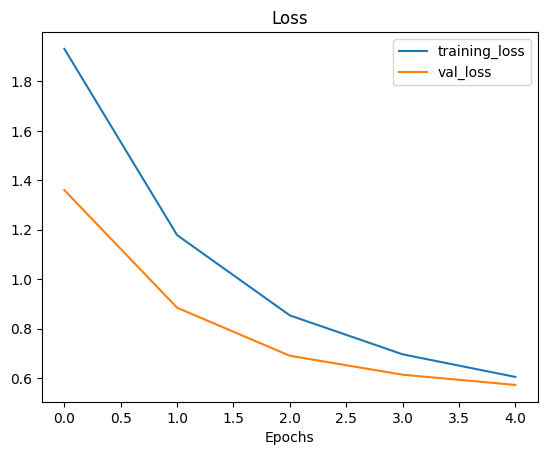

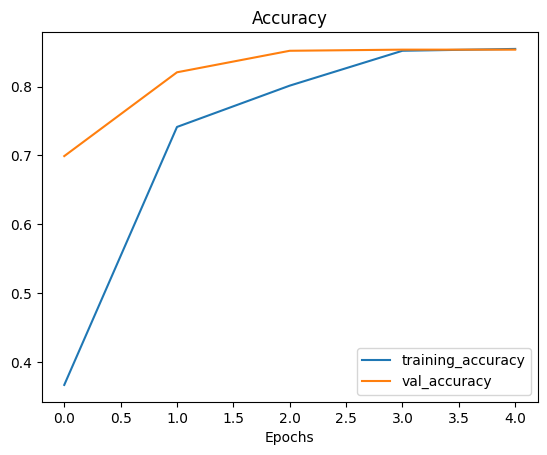

In [18]:
plot_loss_curves(history0)

## Getting feature vector of trained model

When our tensor was passed through the `base_model`, its shape was (None,7,7,1280).

And after it passed through `GlobalAveragePooling2D` its shape became (None, 1280).

Let's pass a random tensor of shape (1,4,4,3) through `GlobalAveragePooling2D` and see what is the shape

In [19]:
tf.random.set_seed(42)

input_shape=(1,4,4,3)

input_tensor=tf.random.normal(input_shape)

print(f"Random tensor is :\n {input_tensor}")

Random tensor is :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [20]:
global_avg_pool_tensor= tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"Global pooled tensor: \n {global_avg_pool_tensor} \n")

Global pooled tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 



Takes the mean across the axes [1,2] of a 4d tensor

In [21]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [22]:
global_max_pool_tensor= tf.keras.layers.GlobalMaxPool2D()(input_tensor)

print(f"Max pooled tensor: \n {global_max_pool_tensor} \n")

Max pooled tensor: 
 [[0.9058464 1.1603122 1.6994323]] 



In [23]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

These values are the features which are then passed to the output layer of the model. These are the important features from which the model learns. It is called Feature vector

## Running experiments with transfer learning

We have already seen how good results a transfer-learning model can provide us with only 10% of data. How about 1%


1. `model1`- feature extraction + 1% data + data augmentation
2. `model2`- feature extration + 10% data + data augmentation
3. `model3`- fine tuning + 10% data + data augmentation
4. `model4` - fine tuning + 100% data + data augmentation


**Note:** Test data will be same across all the experiments for consistent evaluation metrics


In [24]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2023-08-20 15:15:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.3MB/s    in 6.5s    

2023-08-20 15:15:39 (19.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [26]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

## Model1

### Preprocessing data

In [27]:
train_data_1_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation right into the model

Here, data augmentation is included as a layer in the model

In [28]:
data_augmentation= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
    # tf.keras.layers.experimental.preprocessing.Rescale(1/255.)
], name="data_augmentation_layer")

10_food_classes_1_percent/train/sushi


Text(0.5, 1.0, 'Augmented Image from: sushi')

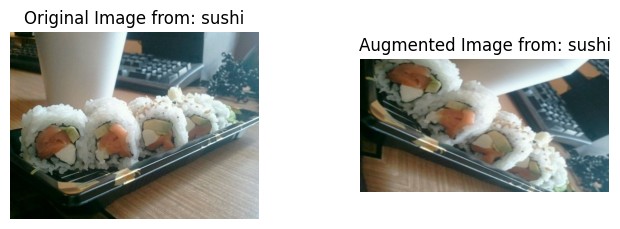

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class= random.choice(train_data_1_percent.class_names)
target_dir= train_dir_1_percent+"/"+ target_class
print(target_dir)

random_img= random.sample(os.listdir(target_dir),1)
img_path= target_dir+"/"+ random_img[0]

img= mpimg.imread(img_path)
plt.subplot(1,2,1)
plt.tight_layout(w_pad=5)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original Image from: {target_class}")

plt.subplot(1,2,2)
plt.tight_layout(w_pad=5)
augmented_img= data_augmentation(img)
plt.imshow(augmented_img/255.)
plt.axis(False)
plt.title(f"Augmented Image from: {target_class}")

In [30]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Building model

In [31]:
IMG_SIZE

(224, 224)

In [32]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# For layers we pass `x` after `()` but for models, it is `(x)`

# create input layer

inputs= tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

# Add data augmentation layer
x= data_augmentation(inputs)

# Give inputs to base model after augmentation and not training it
x= base_model(x, training=False)

# Add GlobalAveragePooling2D layer
x= tf.keras.layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)

# Dense output layer
outputs= tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combining the model with inputs and outputs
model1= tf.keras.Model(inputs, outputs)

# Compile
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# fitting the data
history1=model1.fit(train_data_1_percent,
           epochs=5,
           steps_per_epoch=len(train_data_1_percent),
           validation_data=test_data,
           validation_steps=int(0.25*len(test_data)),
           callbacks=[create_tensorboard_callback("transfer_learning", "model-1")])


Saving TensorBoard log files to: transfer_learning/model-1/20230820-151544
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.3826 - accuracy: 0.1571 - val_loss: 2.1627 - val_accuracy: 0.2516
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1255 - accuracy: 0.2714 - val_loss: 2.0578 - val_accuracy: 0.3306
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9354 - accuracy: 0.4857 - val_loss: 1.9682 - val_accuracy: 0.3898
Epoch 4/5
3/3 [==============================] - 8s 3s/step - loss: 1.8530 - accuracy: 0.5429 - val_loss: 1.8815 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7177 - accuracy: 0.6286 - val_loss: 1.7997 - val_accuracy: 0.4720


In [33]:
results1= model1.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 1.7878 - accuracy: 0.4712


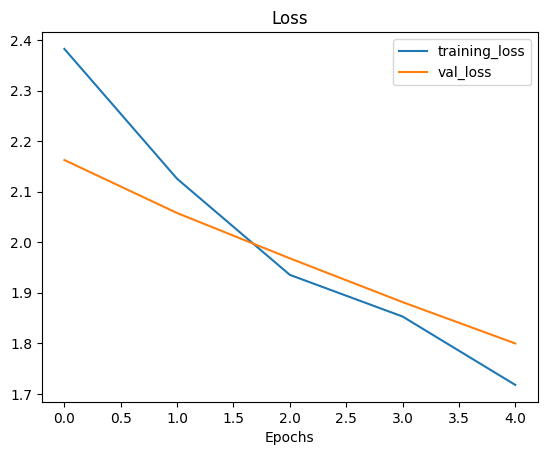

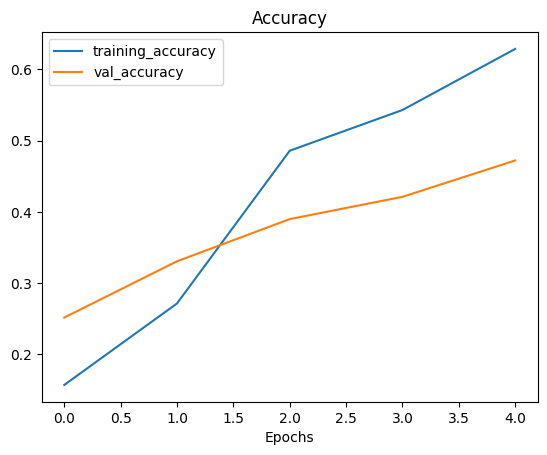

In [34]:
plot_loss_curves(history1)

## Model2

In [35]:
train_dir_10_percent="10_food_classes_10_percent/train"

In [36]:
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)
# test data is same as before

Found 750 files belonging to 10 classes.


### Data Augmentation

In [37]:
data_augmentation= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

### Building the model

In [139]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

x= data_augmentation(inputs)

x= base_model(x, training=False)

x= tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)

outputs= tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2=tf.keras.Model(inputs, outputs)


model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer="Adam",
               metrics=["accuracy"])


### Model Check point

In [140]:
checkpoint_path="checkpoint_weights_10_percent/checkpoint.ckpt"

checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        verbose=1)

In [141]:
history2=model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25* len(test_data)),
            callbacks=[create_tensorboard_callback("transfer_learning", "model2"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model2/20230820-170959
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0183 - accuracy: 0.3293
Epoch 1: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 19s 470ms/step - loss: 2.0183 - accuracy: 0.3293 - val_loss: 1.4997 - val_accuracy: 0.6628
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4245 - accuracy: 0.6173
Epoch 2: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 10s 409ms/step - loss: 1.4245 - accuracy: 0.6173 - val_loss: 1.0664 - val_accuracy: 0.7418
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.7307
Epoch 3: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 10s 409ms/step - loss: 1.1079 - accuracy: 0.7307 - val_loss: 0.8162 - val_accuracy: 0.8240
Epoch 4/5
24/24 [=====================

In [143]:
results2=model_2.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6590 - accuracy: 0.8272


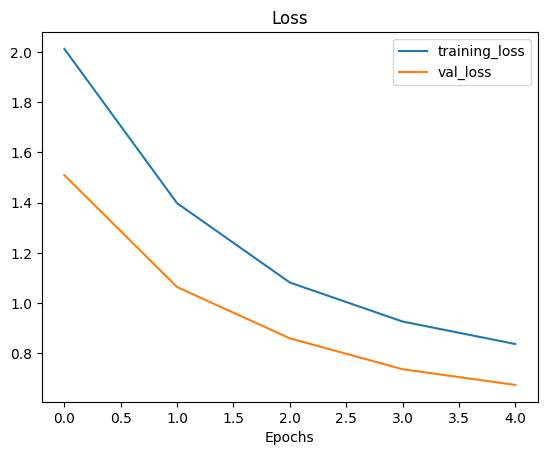

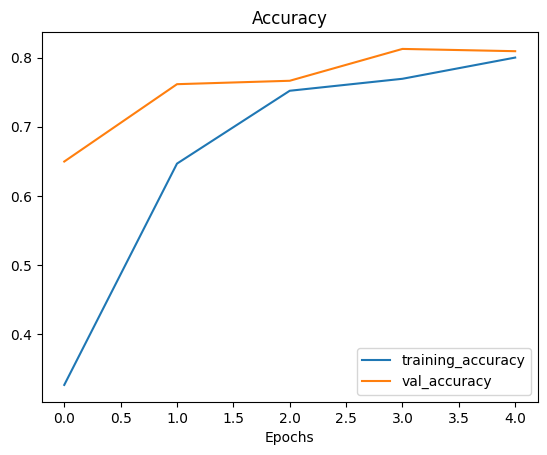

In [98]:
plot_loss_curves(history2)

### Loading in checkpoint weights

In [146]:
model_2.load_weights(checkpoint_path)

In [145]:
loaded_weights_model_results= model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.6590 - accuracy: 0.8272


Even works for previous model

In [144]:
results2

[0.6589634418487549, 0.8271999955177307]

In [147]:
loaded_weights_model_results

[0.6589635014533997, 0.8271999955177307]

## Model3: Fine tuning on 10% of the data

In [148]:
model_2.layers

In [149]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7804a5e23250> True
<keras.engine.sequential.Sequential object at 0x7805523a0880> True
<keras.engine.functional.Functional object at 0x7804a5d67a90> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7804a5e231f0> True
<keras.layers.core.dense.Dense object at 0x7804a5df4460> True


In [150]:
# layers in base model

for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_9 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [151]:
# trainable variables in our base model

print(len(model_2.layers[2].trainable_variables))

0


### Unfreezing the layer

In [152]:
# making last 10 layers of our base model as trainable

# base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [153]:
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_9 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [55]:
inputs= tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

x= data_augmentation(inputs)
x= base_model(x, training=False) # not using augmentation layer for test data
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs= tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model3= tf.keras.Model(inputs, outputs)
model3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # whereverr using fine-tining, reduce lr atleast 10x to prevent overfitting
               metrics=["accuracy"])


In [56]:
checkpoint_path="checkpoint_weights_10_percent/checkpoint_model3.ckpt"

In [57]:
history3=model3.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=[create_tensorboard_callback("transfer_learning", "model3"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model3/20230820-155134
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.1384 - accuracy: 0.2587
Epoch 1: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 34s 919ms/step - loss: 2.1384 - accuracy: 0.2587 - val_loss: 1.8157 - val_accuracy: 0.5000
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.7316 - accuracy: 0.5200
Epoch 2: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 23s 926ms/step - loss: 1.7316 - accuracy: 0.5200 - val_loss: 1.3459 - val_accuracy: 0.6349
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.2767 - accuracy: 0.6360
Epoch 3: saving model to checkpoint_weights_10_percent/checkpoint.ckpt
24/24 [==============================] - 13s 550ms/step - loss: 1.2767 - accuracy: 0.6360 - val_loss: 0.9674 - val_accuracy: 0.7007
Epoch 4/5
24/24 [=====================

In [68]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_5 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [69]:
results3=model3.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.7083 - accuracy: 0.7680


In [61]:
results2

[0.6577876210212708, 0.8348000049591064]

In [63]:
results3

[0.7083086371421814, 0.7680000066757202]

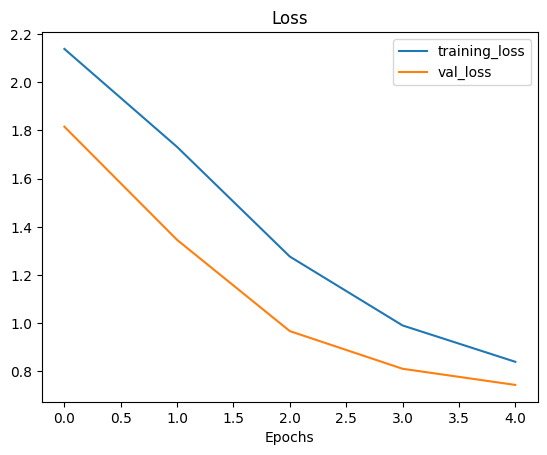

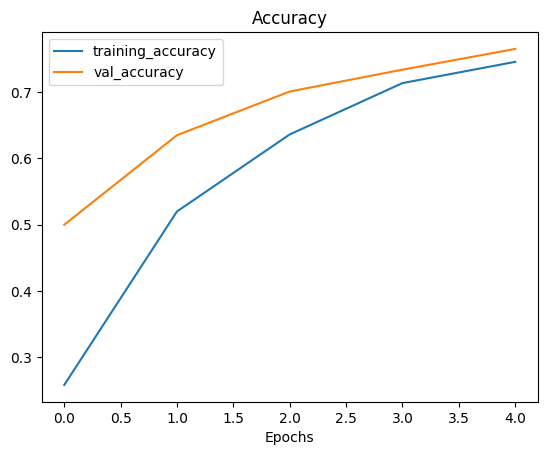

In [64]:
plot_loss_curves(history3)

In [66]:
print(len(model3.trainable_variables))

12


### Recompiling model2 to fit after 5 epochs

In [154]:
fine_tune_epoch=10

history2b= model_2.fit(train_data_10_percent,
                       epochs=fine_tune_epoch,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=int(0.25*len(test_data)),
                       initial_epoch=history2.epoch[-1],
                       callbacks=[create_tensorboard_callback("transfer_learning", "model2a")])

Saving TensorBoard log files to: transfer_learning/model2a/20230820-171902
Epoch 5/10
24/24 [==============================] - 21s 449ms/step - loss: 0.6976 - accuracy: 0.8213 - val_loss: 0.5601 - val_accuracy: 0.8092
Epoch 6/10
24/24 [==============================] - 9s 354ms/step - loss: 0.5974 - accuracy: 0.8227 - val_loss: 0.5076 - val_accuracy: 0.8158
Epoch 7/10
24/24 [==============================] - 9s 367ms/step - loss: 0.5319 - accuracy: 0.8360 - val_loss: 0.4581 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 9s 371ms/step - loss: 0.5046 - accuracy: 0.8347 - val_loss: 0.4916 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 9s 363ms/step - loss: 0.4778 - accuracy: 0.8533 - val_loss: 0.4975 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 8s 326ms/step - loss: 0.4753 - accuracy: 0.8507 - val_loss: 0.4316 - val_accuracy: 0.8454


In [155]:
results2a= model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.4343 - accuracy: 0.8480


In [156]:
results2a

[0.43433359265327454, 0.8479999899864197]

In [157]:
results2

[0.6589634418487549, 0.8271999955177307]

In [109]:
results3

[0.7083086371421814, 0.7680000066757202]

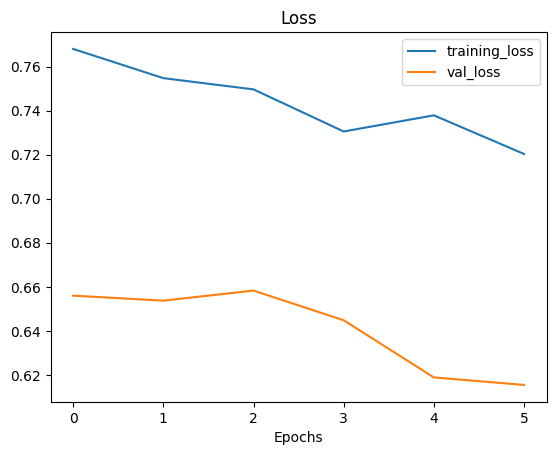

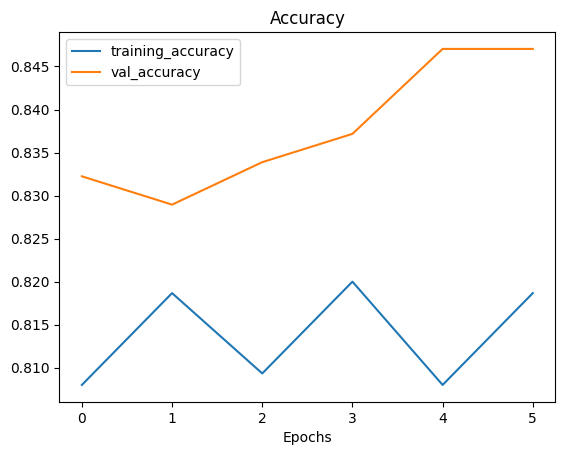

In [76]:
plot_loss_curves(history2b)

In [87]:
def compare_history(old_history, new_history, initial_epochs=5):

  """
  Compares history after fine tuning
  """

  acc=old_history.history["accuracy"]
  loss=old_history.history["loss"]
  val_acc=old_history.history["val_accuracy"]
  val_loss=old_history.history["val_loss"]

  total_acc= acc+ new_history.history["accuracy"]
  total_loss= loss+ new_history.history["loss"]
  total_val_acc= val_acc+ new_history.history["val_accuracy"]
  total_val_loss= val_loss+ new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="training_accuracy")
  plt.plot(total_val_acc, label="validaiton_accuracy")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="lower right")

  plt.title("Training and Validation accuracy")

  # plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="training_loss")
  plt.plot(total_val_loss, label="validaiton_loss")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="upper right")

  plt.title("Training and Validation loss")

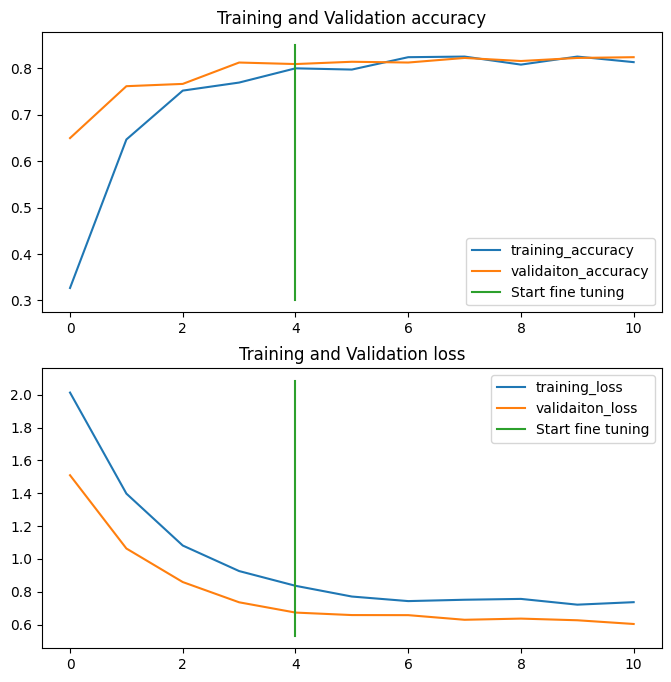

In [110]:
compare_history(history2, history2b)

## Model 4

Fine tunign works better with more data. The pattern here is, we normally fit our data by feature extraction and then fine-tune the model

### Getting data

In [89]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")


--2023-08-20 16:30:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.8MB/s    in 24s     

2023-08-20 16:30:40 (20.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [90]:
train_dir="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [91]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

### Preprocessing data

In [93]:
train_data= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical")



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [161]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6590 - accuracy: 0.8272


[0.6589635610580444, 0.8271999955177307]

In [162]:
results2

[0.6589634418487549, 0.8271999955177307]

### What did we do till now:

1. Trained a feature extraction model for 5 epochs on 10% of the data and saved it's weights using `ModelCheckpoint` callback
2. Fine-tune the same model for more 5 epochs after unfreezing last 10 layers.
3. We saved the results and training log each time.
4. We reloaded the model from step 1 and to do same as step 2 but this time, we use all the data

In [158]:
for layer_num, layer in enumerate(model_2.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetv2-b0 True
3 global_avg_pooling True
4 output_layer True


In [159]:
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_9 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [164]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [166]:
history4= model_2.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=train_data,
                      validation_steps=int(0.25*len(test_data)),
                      initial_epoch= history2.epoch[-1],
                      callbacks=[create_tensorboard_callback("transfer_learning", "model4")])

Saving TensorBoard log files to: transfer_learning/model4/20230820-172729
Epoch 5/10
235/235 [==============================] - 75s 243ms/step - loss: 0.7061 - accuracy: 0.7708 - val_loss: 0.4154 - val_accuracy: 0.8520
Epoch 6/10
235/235 [==============================] - 53s 223ms/step - loss: 0.5953 - accuracy: 0.8120 - val_loss: 0.3224 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 47s 196ms/step - loss: 0.5399 - accuracy: 0.8231 - val_loss: 0.3129 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 46s 193ms/step - loss: 0.5055 - accuracy: 0.8343 - val_loss: 0.2918 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 51s 215ms/step - loss: 0.4798 - accuracy: 0.8436 - val_loss: 0.2819 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 41s 174ms/step - loss: 0.4605 - accuracy: 0.8532 - val_loss: 0.2521 - val_accuracy: 0.9178


In [167]:
result4= model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.2652 - accuracy: 0.9108


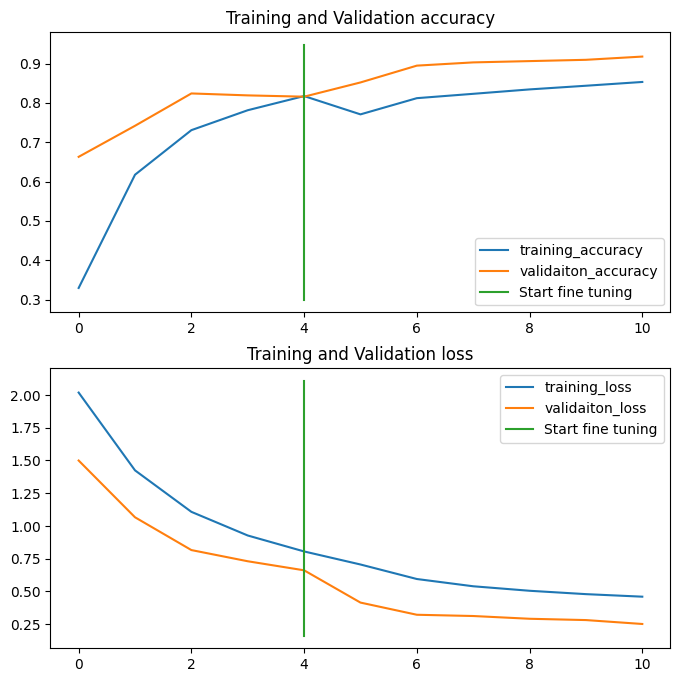

In [168]:
compare_history(history2, history4)

## Viewing experiments on tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name 'Transfer learning experiments'  \
--description "Series of feature extraction and fine tune models" \
--one_shot

## TensorBoard

In [170]:
!tensorboard dev list

2023-08-20 17:46:44.859846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/E5vN6Xa8RrSo5DFg6GeuBw/
	Name                 Transfer learning experiments 
	Description          Series of feature extraction and fine tune models
	Id                   E5vN6Xa8RrSo5DFg6GeuBw
	Created              2023-08-20 17:39:55 (6 minutes ago)
	Updated              2023-08-20 17:40:15 (6 minutes ago)
	Runs                 22
	Tags                 5
	Scalars              360
	Tensor bytes         0
	Binary object bytes  11367536
https://tensorboard.dev/experiment/j8rQAwrERUm2CRPzmg2vgQ/
	Name                 MobilenetV2
	Description          Comparing two different TF hub feature extraction
	Id                   j8rQAwrERUm2CRPzmg2vgQ
	Created              2023-08-16 09:49:22
	Updated              2023-08-16 09:49:26
	Runs                 4
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary o

## To delete any experiment

`!tensorboard dev delete --experiment_id [id]`